# Gradient Boosted Tree Based Model using CatBoost
Author: Riley Denn  
Team Fermata Energy

In [43]:
import numpy as np
import pandas as pd
import json
import os
from catboost import CatBoostRegressor, Pool, sum_models
import gc
import random
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import kaleido


In [5]:
with open('../../config.json', 'r') as config_file:
    config = json.load(config_file)

DRIVE_PATH = config['drive_path']
EXTERNAL_DATA_PATH = DRIVE_PATH + "/[EXTERNAL] breakthrough_tech_ai_f24/data"
PROCESSED_DATA_PATH = DRIVE_PATH + "/processed_data"
PROCESSED_WEATHER_LOAD = PROCESSED_DATA_PATH + "/processed_weather_load_w_timestamp"

In [6]:
# Approx ~6400 buildings in subset20
# with open('../data/subset20_data.json', 'r') as test_train_file:
#     test_train_ids = json.load(test_train_file)

# Approx ~1300 buildings in subset20_20
with open('../data/subset20_20_data.json', 'r') as downsampled_test_train_file:
    downsampled_test_train_ids = json.load(downsampled_test_train_file)

# train_ids = [int(bldg_id.replace('.csv', '')) for bldg_id in test_train_ids['train_bldg_ids']]
# test_ids = [int(bldg_id.replace('.csv', '')) for bldg_id in test_train_ids['test_bldg_ids']]

downsampled_train_ids = [int(bldg_id.replace('.csv', '')) for bldg_id in downsampled_test_train_ids['train_bldg_ids']]
downsampled_test_ids = [int(bldg_id.replace('.csv', '')) for bldg_id in downsampled_test_train_ids['test_bldg_ids']]

In [7]:
df_metadata = pd.read_csv("../preprocessing/md_encoded_categorical_subset20.csv")
downsampled_df_metadata = df_metadata[
    (df_metadata["bldg_id"].isin(downsampled_train_ids)) | 
    (df_metadata["bldg_id"].isin(downsampled_test_ids))
]
downsampled_md_education = downsampled_df_metadata[downsampled_df_metadata['in.comstock_building_type_group']=="Education"]

downsampled_education_train_ids = [id for id in downsampled_train_ids if (id in downsampled_md_education["bldg_id"].values)]
downsampled_education_test_ids = [id for id in downsampled_test_ids if (id in downsampled_md_education["bldg_id"].values)]

downsampled_md_education

,bldg_id,in.building_america_climate_zone,in.state,in.heating_fuel,in.interior_lighting_generation,in.service_water_heating_fuel,in.comstock_building_type_group,in.vintage,in.sqft
18,1025,Mixed-Humid,AL,Electricity,gen4_led,NaturalGas,Education,4,75000.0
122,5623,Subarctic,AK,DistrictHeating,gen1_t12_incandescent,DistrictHeating,Education,4,17500.0
123,5778,Very Cold,AK,DistrictHeating,gen2_t8_halogen,Electricity,Education,4,150000.0
127,6141,Hot-Dry,AZ,Electricity,gen2_t8_halogen,Electricity,Education,5,37500.0
137,7137,Hot-Dry,AZ,NaturalGas,gen4_led,Electricity,Education,3,75000.0
...,...,...,...,...,...,...,...,...,...
6267,325574,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,Education,2,37500.0
6268,325656,Cold,VT,NaturalGas,gen1_t12_incandescent,NaturalGas,Education,4,150000.0
6269,325674,Cold,VT,NaturalGas,gen1_t12_incandescent,Electricity,Education,4,37500.0
6356,329909,Mixed-Humid,VA,NaturalGas,gen4_led,NaturalGas,Education,4,75000.0


In [8]:
downsampled_md_education.dtypes

bldg_id                               int64
in.building_america_climate_zone     object
in.state                             object
in.heating_fuel                      object
in.interior_lighting_generation      object
in.service_water_heating_fuel        object
in.comstock_building_type_group      object
in.vintage                            int64
in.sqft                             float64
dtype: object

In [171]:
def prep_building_df(bldg_id, df_metadata, downsample_time=True, prediction_interval="hourly", one_bldg_type=True):
    """ 
    Combines the metadata with building data for the given building.
    Shifts max and min hourly load and temp to the value from previous hour and 
    drops original max and min hourly load and temp.
    Additionally, drops the minute and bldg_id columns.

    bldg_id : the building id of the building to be prepped
    df_metadata : dataframe containing the metadata of all the buildings where 
        each row corresponds to a unique building id
    downsample_time : if true, downsamples by only including the rows at the top of each hour
    prediction_interval : options - "current_only", "2_hr", "hourly", "15_min"

    Returns : X (features) and y (label) for the given building.
    """
    
    # Check for known error buildings
    error_bldgs = [309849, 241890, 56518]  # List of buildings to skip due to known google drive errors
    if bldg_id in error_bldgs:
            print(f"Known error for building {bldg_id}")
            return df_bldg

    try:
        df_bldg = pd.read_csv(f"{PROCESSED_WEATHER_LOAD}/{bldg_id}.csv")
    except Exception as e:
        print(f"Skipping building {bldg_id} due to error: {e}")
        return df_bldg


    # Set time factor based on whether downsample_time is True or False
    if downsample_time == True:
        time_factor = 1
        # Validate that prediction_interval is suitable for downsampled time 
        if (prediction_interval == "15_min"):
            prediction_interval = "hourly"
            print(f"Cannot predict in 15 min intervals on downsampled time data. Using {prediction_interval} prediction instead.")
    else:
        time_factor = 4

    # Merge df_bldg with metadata
    bldg_metadata = df_metadata[df_metadata['bldg_id'] == bldg_id]
    df_bldg = df_bldg.merge(bldg_metadata, on='bldg_id', how='left')
    df_bldg.set_index('timestamp', inplace=True)
    
    # Optionally downsample to only rows from top of the hour
    if downsample_time == True:
        df_bldg = df_bldg[df_bldg['minute'] == 0]

    # Create lag columns for max and min hourly load and temp
    max_min_hourly_lag_vals = [l for l in range(1, 4)]
    for lag in max_min_hourly_lag_vals:
        df_bldg[f'max_load_hourly_lag{lag}'] = df_bldg['max_load_hourly'].shift(lag*time_factor)
        #df_bldg[f'min_load_hourly_lag{lag}'] = df_bldg['min_load_hourly'].shift(lag*time_factor)
        if (lag !=2):
            df_bldg[f'max_temp_hourly_lag{lag}'] = df_bldg['max_temp_hourly'].shift(lag*time_factor)
            #df_bldg[f'min_temp_hourly_lag{lag}'] = df_bldg['min_temp_hourly'].shift(lag*time_factor)

    # Create columns to show the differences in lagged load and temp
    df_bldg[f'max_load_hourly_diff'] = df_bldg[f'max_load_hourly_lag1'] - df_bldg[f'max_load_hourly_lag3']
    df_bldg[f'max_temp_hourly_diff'] = df_bldg[f'max_temp_hourly_lag1'] - df_bldg[f'max_temp_hourly_lag3']

    # Create column to indicate whether or not it's a workday
    df_bldg['is_workday'] = df_bldg['is_weekday'] & ~df_bldg['is_holiday']
    
    # Remove columns
    df_bldg = df_bldg.drop(columns=['max_load_hourly', 'min_load_hourly', 'max_temp_hourly', 'min_temp_hourly', 'minute', 'day', 'is_weekday', 'is_holiday'])


    predict_scale_dict = {
        "current_only" : 1, 
        "2_hr" : 12,
        "hourly" : 24, 
        "15_min" : 96
    }

   # Check if the prediction_interval is valid
    if prediction_interval not in predict_scale_dict.keys():
        raise ValueError(
            f"Invalid value for prediction_interval. Use one of: {', '.join(predict_scale_dict.keys())}."
        )

    predict_scale = predict_scale_dict[prediction_interval]

    # Create all future prediction shifts
    future_shifts = {}
    if (prediction_interval != "current only"):
        predict_multiplier = 96 / predict_scale # predict_scale 12 : multiplier 8, predict_scale 24 : multiplier 4, predict_scale 96 : multiplier 1
        future_shifts = {
            f'future_shift_{i}': df_bldg['out.electricity.total.energy_consumption'].shift(int((-i*predict_multiplier)/(4/time_factor)))
            for i in range(1, predict_scale)
        }
    
        future_shifts_df = pd.DataFrame(future_shifts, index=df_bldg.index)
        
        # Concatenate the future shifts to the original DataFrame
        df_bldg = pd.concat([df_bldg, future_shifts_df], axis=1)
        
        # Optionally create a defragmented copy
        df_bldg = df_bldg.copy()

    df_bldg = df_bldg.dropna()

    # Change data types of features for memory efficiency
    categorical_features = df_bldg.select_dtypes(include=['object', 'category']).columns.tolist()
    float_features = df_bldg.select_dtypes(include=['float64']).columns.tolist()
    int_features = df_bldg.select_dtypes(include=['int64']).columns.tolist()
    
    for col in categorical_features:
        df_bldg[col] = pd.Categorical(df_bldg[col])
    df_bldg[float_features] = df_bldg[float_features].astype('float32')
    df_bldg[int_features] = df_bldg[int_features].astype('int32')
    
    # Apply normalization to numerical features
    numerical_features = float_features + int_features
    numerical_features = list(set(float_features + int_features) - {'out.electricity.total.energy_consumption'})

    # Add future_shifts exclusion if 'future_shifts' exists
    if future_shifts:
        numerical_features = list(set(numerical_features) - set(future_shifts.keys()))
    #numerical_features = list(set(float_features + int_features) - {'out.electricity.total.energy_consumption'} - set(future_shifts.keys))

    scaler = StandardScaler()
    df_bldg[numerical_features] = scaler.fit_transform(df_bldg[numerical_features])

    X = df_bldg.drop(columns=['out.electricity.total.energy_consumption', 'bldg_id', 
                              'in.sqft', 'in.vintage'] 
                     + [f'future_shift_{int(i)}' for i in range(1, predict_scale)]
                    )
    if one_bldg_type:
        X = X.drop(columns=['in.comstock_building_type_group'])
    
    y = df_bldg[['out.electricity.total.energy_consumption'] + [f'future_shift_{i}' for i in range(1, predict_scale)]]

    return X, y
    

In [135]:
def load_all_data(df_metadata, bldg_ids, downsample_time=True, prediction_interval="hourly", save_csv=False, 
                  base_filename="_train.csv", one_bldg_type=True):
    """
    Creates a combined dataframe by first calling prep_building_df for each building to combine the metadata with building data, 
    then concatenates each building's data together to create one large dataframe.
    Creates X (features) and y (label) dataframes from the combined dataframe.
    Returns X and y.
    """
    error_bldgs = [309849, 241890, 56518]  # List of buildings to skip due to known google drive errors
    
    X_combined = pd.DataFrame()
    y_combined = pd.DataFrame()
    
    # Loop through each building and process
    for bldg_id in bldg_ids:
        if bldg_id in error_bldgs:
            print(f"Error for building {bldg_id}")
            continue
        X, y = prep_building_df(bldg_id, df_metadata, downsample_time=downsample_time, 
                                prediction_interval=prediction_interval, one_bldg_type=one_bldg_type)
        
        X_combined = pd.concat([X_combined, X], ignore_index=True)
        y_combined = pd.concat([y_combined, y], ignore_index=True)
        
        gc.collect()
    
    if save_csv:
        X_combined.to_csv("X"+base_filename, index=False)
        y_combined.to_csv("y"+base_filename, index=False)
        print(f"Combined data saved to X{base_filename} and y{base_filename}")
    
    return X_combined, y_combined

In [11]:
def calculate_smape(actual, predicted):
    numerator = np.abs(predicted - actual)
    denominator = (np.abs(actual) + np.abs(predicted))/2
    diff = numerator / denominator
    smape = np.nanmean(diff) * 100  # Multiply by 100 to get percentage
    return smape

In [12]:
sample_bldg_id = downsampled_education_train_ids[0]
sample_df = pd.read_csv(f"{PROCESSED_WEATHER_LOAD}/{sample_bldg_id}.csv")
sample_df

,timestamp,out.electricity.total.energy_consumption,Dry Bulb Temperature [°C],Relative Humidity [%],heat_index,minute,hour,day,month,is_weekday,is_holiday,max_load_hourly,min_load_hourly,max_temp_hourly,min_temp_hourly,bldg_id
0,2018-01-01 01:00:00,5.090486,-21.130769,75.957692,-6.035385,0,1,1,1,1,1,5.132093,5.078161,-21.130769,-22.151442,325574
1,2018-01-01 01:15:00,5.109079,-21.470994,76.101186,-6.647788,15,1,1,1,1,1,5.132093,5.078161,-21.130769,-22.151442,325574
2,2018-01-01 01:30:00,5.078161,-21.811218,76.244679,-7.260192,30,1,1,1,1,1,5.132093,5.078161,-21.130769,-22.151442,325574
3,2018-01-01 01:45:00,5.132093,-22.151442,76.388173,-7.872596,45,1,1,1,1,1,5.132093,5.078161,-21.130769,-22.151442,325574
4,2018-01-01 02:00:00,5.129411,-22.491667,76.531667,-8.485000,0,2,1,1,1,1,5.175283,5.108162,-22.491667,-24.292147,325574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35032,2018-12-31 23:00:00,3.927416,1.113333,95.774000,34.004000,0,23,31,12,1,0,3.928954,3.875137,1.533333,1.113333,325574
35033,2018-12-31 23:15:00,3.928954,1.253333,95.618167,34.256000,15,23,31,12,1,0,3.928954,3.875137,1.533333,1.113333,325574
35034,2018-12-31 23:30:00,3.875137,1.393333,95.462333,34.508000,30,23,31,12,1,0,3.928954,3.875137,1.533333,1.113333,325574
35035,2018-12-31 23:45:00,3.916088,1.533333,95.306500,34.760000,45,23,31,12,1,0,3.928954,3.875137,1.533333,1.113333,325574


In [134]:
X_sample, y_sample = prep_building_df(sample_bldg_id, df_metadata, downsample_time=True, prediction_interval="2_hr")
X_sample

,Dry Bulb Temperature [°C],Relative Humidity [%],heat_index,hour,month,in.building_america_climate_zone,in.state,in.heating_fuel,in.interior_lighting_generation,in.service_water_heating_fuel,max_load_hourly_lag1,max_temp_hourly_lag1,max_load_hourly_lag2,max_load_hourly_lag3,max_temp_hourly_lag3,max_load_hourly_diff,max_temp_hourly_diff,is_workday
timestamp,,,,,,,,,,,,,,,,,,
2018-01-01 04:00:00,-2.908905,0.337993,-3.008766,-1.083645,-1.603180,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,-0.518565,-2.933142,-0.522981,-0.529971,-2.611035,0.021684,-1.504691,-1.482326
2018-01-01 05:00:00,-2.750129,0.103376,-2.833721,-0.939178,-1.603180,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,-0.522530,-2.813029,-0.518589,-0.522992,-2.728105,0.000865,-0.389850,-1.482326
2018-01-01 06:00:00,-2.907819,0.182466,-3.007569,-0.794710,-1.603180,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,-0.444568,-2.773432,-0.522554,-0.518600,-2.930648,0.140833,0.748562,-1.482326
2018-01-01 07:00:00,-3.062372,0.313575,-3.177956,-0.650243,-1.603180,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,-0.091532,-2.930734,-0.444592,-0.522565,-2.810620,0.820041,-0.554922,-1.482326
2018-01-01 08:00:00,-3.097434,0.381057,-3.216611,-0.505776,-1.603180,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,0.519935,-3.084906,-0.091551,-0.444602,-2.771052,1.835054,-1.465373,-1.482326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30 22:00:00,-0.936656,0.517467,-0.834444,1.516765,1.594229,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,-0.512345,-0.944560,-0.460033,-0.524353,-0.879963,0.022829,-0.300561,-1.482326
2018-12-30 23:00:00,-0.936294,0.514548,-0.834044,1.661233,1.594229,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,-0.616811,-0.964155,-0.512370,-0.460043,-0.899815,-0.298270,-0.299288,-1.482326
2018-12-31 00:00:00,-0.936656,0.528938,-0.834444,-1.661514,1.594229,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,-0.557337,-0.964065,-0.616836,-0.512380,-0.943489,-0.085546,-0.093508,0.674615


In [136]:
y_sample.head(10)

,out.electricity.total.energy_consumption,future_shift_1,future_shift_2,future_shift_3,future_shift_4,future_shift_5,future_shift_6,future_shift_7,future_shift_8,future_shift_9,future_shift_10,future_shift_11
timestamp,,,,,,,,,,,,
2018-01-01 04:00:00,5.177929,5.704369,12.456624,14.227500,14.876543,14.647543,12.579439,12.648863,9.215419,5.560380,5.402590,5.527623
2018-01-01 05:00:00,5.559959,9.800547,13.325277,14.428550,14.894785,14.070948,13.134590,12.484546,6.198101,5.725791,5.470519,5.307441
2018-01-01 06:00:00,5.704369,12.456624,14.227500,14.876543,14.647543,12.579439,12.648863,9.215419,5.560380,5.402590,5.527623,5.594862
2018-01-01 07:00:00,9.800547,13.325277,14.428550,14.894785,14.070948,13.134590,12.484546,6.198101,5.725791,5.470519,5.307441,5.389002
2018-01-01 08:00:00,12.456624,14.227500,14.876543,14.647543,12.579439,12.648863,9.215419,5.560380,5.402590,5.527623,5.594862,5.845545
2018-01-01 09:00:00,13.325277,14.428550,14.894785,14.070948,13.134590,12.484546,6.198101,5.725791,5.470519,5.307441,5.389002,9.985678
2018-01-01 10:00:00,14.227500,14.876543,14.647543,12.579439,12.648863,9.215419,5.560380,5.402590,5.527623,5.594862,5.845545,12.261153
2018-01-01 11:00:00,14.428550,14.894785,14.070948,13.134590,12.484546,6.198101,5.725791,5.470519,5.307441,5.389002,9.985678,13.295590
2018-01-01 12:00:00,14.876543,14.647543,12.579439,12.648863,9.215419,5.560380,5.402590,5.527623,5.594862,5.845545,12.261153,14.505203


In [17]:
# V2, V3 create X_train and y_train mega dataframes
X_train, y_train = load_all_data(df_metadata, 
                                 downsampled_education_train_ids,
                                 downsample_time=True, 
                                 prediction_interval="2_hr",
                                 save_csv=True, 
                                 base_filename="_cat_V2downsampled_education_train_2hour.csv",
                                 one_bldg_type=True)

Combined data saved to X_V2downsampled_education_train_2hour.csv and y_V2downsampled_education_train_2hour.csv


In [18]:
# V2, V3 create X_test and y_test mega dataframes
X_test, y_test = load_all_data(df_metadata, 
                                 downsampled_education_train_ids,
                                 downsample_time=False, 
                                 prediction_interval="2_hr",
                                 save_csv=True,
                                 base_filename="_cat_V2downsampled_education_test_2hour.csv",
                                 one_bldg_type=True)

Combined data saved to X_V2downsampled_education_test_2hour.csv and y_V2downsampled_education_test_2hour.csv


In [19]:
X_train

,Dry Bulb Temperature [°C],Relative Humidity [%],heat_index,hour,month,in.building_america_climate_zone,in.state,in.heating_fuel,in.interior_lighting_generation,in.service_water_heating_fuel,max_load_hourly_lag1,max_temp_hourly_lag1,max_load_hourly_lag2,max_load_hourly_lag3,max_temp_hourly_lag3,max_load_hourly_diff,max_temp_hourly_diff,is_workday
0,-2.908905,0.337993,-3.008766,-1.083645,-1.603180,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,-0.518565,-2.933142,-0.522981,-0.529971,-2.611035,0.021684,-1.504691,-1.482326
1,-2.750129,0.103376,-2.833721,-0.939178,-1.603180,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,-0.522530,-2.813029,-0.518589,-0.522992,-2.728105,0.000865,-0.389850,-1.482326
2,-2.907819,0.182466,-3.007569,-0.794710,-1.603180,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,-0.444568,-2.773432,-0.522554,-0.518600,-2.930648,0.140833,0.748562,-1.482326
3,-3.062372,0.313575,-3.177956,-0.650243,-1.603180,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,-0.091532,-2.930734,-0.444592,-0.522565,-2.810620,0.820041,-0.554922,-1.482326
4,-3.097434,0.381057,-3.216611,-0.505776,-1.603180,Cold,VT,FuelOil,gen2_t8_halogen,Electricity,0.519935,-3.084906,-0.091551,-0.444602,-2.771052,1.835054,-1.465373,-1.482326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118075,-0.714605,0.678272,-0.682105,1.516765,1.594229,Very Cold,MN,Electricity,gen2_t8_halogen,Electricity,0.024000,-0.745728,0.003357,-0.019592,-0.763644,0.055188,0.102850,-1.482326
1118076,-0.664344,0.678272,-0.629755,1.661233,1.594229,Very Cold,MN,Electricity,gen2_t8_halogen,Electricity,0.026661,-0.701828,0.023871,0.003220,-0.763644,0.029678,0.348072,-1.482326
1118077,-0.689475,1.052953,-0.655930,-1.661514,1.594229,Very Cold,MN,Electricity,gen2_t8_halogen,Electricity,-1.071386,-0.689285,0.026532,0.023735,-0.744842,-1.386481,0.313040,0.674615
1118078,-0.739735,1.052953,-0.708280,-1.517046,1.594229,Very Cold,MN,Electricity,gen2_t8_halogen,Electricity,-1.019648,-0.714371,-1.071544,0.026396,-0.700970,-1.324347,-0.072309,0.674615


In [20]:
y_train

,out.electricity.total.energy_consumption,future_shift_1,future_shift_2,future_shift_3,future_shift_4,future_shift_5,future_shift_6,future_shift_7,future_shift_8,future_shift_9,future_shift_10,future_shift_11
0,5.177929,5.704369,12.456624,14.227500,14.876543,14.647543,12.579439,12.648863,9.215419,5.560380,5.402590,5.527623
1,5.559959,9.800547,13.325277,14.428550,14.894785,14.070948,13.134590,12.484546,6.198101,5.725791,5.470519,5.307441
2,5.704369,12.456624,14.227500,14.876543,14.647543,12.579439,12.648863,9.215419,5.560380,5.402590,5.527623,5.594862
3,9.800547,13.325277,14.428550,14.894785,14.070948,13.134590,12.484546,6.198101,5.725791,5.470519,5.307441,5.389002
4,12.456624,14.227500,14.876543,14.647543,12.579439,12.648863,9.215419,5.560380,5.402590,5.527623,5.594862,5.845545
...,...,...,...,...,...,...,...,...,...,...,...,...
1118075,30.714312,9.512384,15.239533,16.145945,18.530849,88.395309,60.884762,57.198727,52.082241,52.272541,45.125645,40.359142
1118076,8.939372,10.321108,16.566525,16.846493,44.893696,84.174126,62.365929,55.536331,55.027767,79.165390,46.081081,39.623222
1118077,9.512384,15.239533,16.145945,18.530849,88.395309,60.884762,57.198727,52.082241,52.272541,45.125645,40.359142,38.166698
1118078,10.321108,16.566525,16.846493,44.893696,84.174126,62.365929,55.536331,55.027767,79.165390,46.081081,39.623222,14.523803


In [22]:
# V3 X_train_gs and y_train_gs : smaller subset of education buildings
# from subset20_20 to be used for grid search
grid_search_sample_ids = random.sample(downsampled_education_train_ids, 
                                    int(0.4 * len(downsampled_education_train_ids)))
X_train_gs, y_train_gs = load_all_data(df_metadata, 
                                 grid_search_sample_ids,
                                 downsample_time=True, 
                                 prediction_interval="2_hr",
                                 save_csv=True, 
                                 base_filename="_cat_V3smaller_downsampled_education_train_2hour.csv",
                                 one_bldg_type=True)

Combined data saved to X_cat_V3smaller_downsampled_education_train_2hour.csv and y_cat_V3smaller_downsampled_education_train_2hour.csv


In [23]:
len(grid_search_sample_ids)

51

In [231]:
# V3 Grid search and final model training
categorical_features = X_train_gs.select_dtypes(include=['object', 'category']).columns.tolist()

train_pool_sampled = Pool(data=X_train_gs, label=y_train_gs, cat_features=categorical_features)
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)

# Define the parameter grid
param_grid = {
    'iterations': [500],
    'depth': [8, 10],
    'learning_rate': [0.03, 0.15],
    'early_stopping_rounds': [10]
}

# Initialize the model
model = CatBoostRegressor(task_type="CPU", loss_function='MultiRMSE', verbose=0)

# Perform grid search
grid_search_results = model.grid_search(
    param_grid=param_grid,
    X=train_pool_sampled,
    cv=3,  # Number of cross-validation folds
    partition_random_seed=42,
    verbose=True
)

best_params = grid_search_results['params']
# Best parameters
print("Best parameters:", grid_search_results['params'])
print("Training model with best parameters on larger dataset.")

# Initialize a new model with the best parameters
final_model = CatBoostRegressor(
    task_type="CPU",
    loss_function='MultiRMSE',
    verbose=100,
    **best_params  # Pass the best parameters
)

# Train the model on the full dataset
final_model.fit(train_pool)

# Save the final model
model_filename = 'V3education_catboost_model_tuned.cbm'
final_model.save_model(model_filename)

print(f"Finished training. Model saved to {model_filename}")


bestTest = 67.8286608
bestIteration = 499

0:	loss: 67.8286608	best: 67.8286608 (0)	total: 35m 26s	remaining: 1h 46m 20s

bestTest = 60.94586283
bestIteration = 499

1:	loss: 60.9458628	best: 60.9458628 (1)	total: 1h 13m 23s	remaining: 1h 13m 23s

bestTest = 63.55060514
bestIteration = 499

2:	loss: 63.5506051	best: 60.9458628 (1)	total: 1h 58m 41s	remaining: 39m 33s

bestTest = 57.58878926
bestIteration = 499

3:	loss: 57.5887893	best: 57.5887893 (3)	total: 2h 45m 34s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 57.89313449
bestIteration = 499

Training on fold [1/3]

bestTest = 58.02238933
bestIteration = 499

Training on fold [2/3]

bestTest = 58.31324395
bestIteration = 499

Best parameters: {'depth': 10, 'od_wait': 10, 'learning_rate': 0.15, 'iterations': 500}
Training model with best parameters on larger dataset.
Finished training. Model saved to V3education_catboost_model_tuned.cbm


In [130]:
# V2 model training
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
model = CatBoostRegressor(task_type="CPU", iterations=500, depth=8, learning_rate=0.2, cat_features=categorical_features, loss_function='MultiRMSE',)
model.fit(train_pool, verbose=100, early_stopping_rounds=5)
model.save_model('V2catboost_model_subset_20_20_education_2hr.cbm')

0:	learn: 174.2803556	total: 13.4s	remaining: 1h 51m 27s
100:	learn: 91.1618727	total: 20m 53s	remaining: 1h 22m 31s
200:	learn: 84.9486315	total: 42m 3s	remaining: 1h 2m 34s
300:	learn: 81.6916504	total: 1h 3m 5s	remaining: 41m 42s
400:	learn: 79.5590110	total: 1h 26m 4s	remaining: 21m 15s
499:	learn: 77.9771460	total: 1h 48m 40s	remaining: 0us


In [103]:
# V1 model training
# Note: different lag features used compared to V2 and V3; 
# Function load_all_data() has since been modified
# See feature importances cell below to see all features
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
model = CatBoostRegressor(task_type="CPU", iterations=250, depth=8, learning_rate=0.2, cat_features=categorical_features, loss_function='MultiRMSE',)
model.fit(train_pool, verbose=100, early_stopping_rounds=5)
model.save_model('V1catboost_model_subset_20_20_education_2hr.cbm')

0:	learn: 174.2848322	total: 12.5s	remaining: 51m 41s
100:	learn: 88.8797547	total: 20m 17s	remaining: 29m 56s
200:	learn: 81.6031093	total: 41m 19s	remaining: 10m 4s
249:	learn: 79.5737624	total: 52m 56s	remaining: 0us


In [232]:
# V3 SMAPE scores

# final_model = CatBoostRegressor()
# final_model.load_model('V3education_catboost_model_tuned.cbm')

prediction_train = final_model.predict(X_train)
train_smape = calculate_smape(actual=y_train, predicted=prediction_train)

prediction_test = final_model.predict(X_test)
test_smape = calculate_smape(actual=y_test, predicted=prediction_test)

print(f"train_smape: {train_smape}")
print(f"test_smape: {test_smape}")

train_smape: 37.65940757682346
test_smape: 39.84251067843545


In [132]:
# V2 SMAPE scores

# model = CatBoostRegressor()
# model.load_model('V2catboost_model_subset_20_20_education_2hr.cbm')

prediction_train = model.predict(X_train)
train_smape = calculate_smape(actual=y_train, predicted=prediction_train)

prediction_test = model.predict(X_test)
test_smape = calculate_smape(actual=y_test, predicted=prediction_test)

print(f"train_smape: {train_smape}")
print(f"test_smape: {test_smape}")

train_smape: 41.70559151771402
test_smape: 43.50879865120637


In [106]:
# V1 SMAPE scores

# model = CatBoostRegressor()
# model.load_model('catboost_model_subset_20_20_education_2hr.cbm')

prediction_train = model.predict(X_train)
train_smape = calculate_smape(actual=y_train, predicted=prediction_train)

prediction_test = model.predict(X_test)
test_smape = calculate_smape(actual=y_test, predicted=prediction_test)

print(f"train_smape: {train_smape}")
print(f"test_smape: {test_smape}")

train_smape: 43.176957926955794
test_smape: 44.88075997414408


In [244]:
def plot_feature_importances(model, X_train):
    """
    Plot feature importances from a CatBoost model using Plotly.

    Parameters:
        model (CatBoostRegressor): The trained CatBoost model.
        X_train (pandas.DataFrame): The training data used to train the model.

    Returns:
        fig: Plotly figure object.
    """
    # Get feature importances from the model
    feature_importances = model.get_feature_importance()

    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Create Plotly bar plot
    fig = px.bar(
        importance_df,
        x='Importance',
        y='Feature',
        orientation='h',
        title='CatBoost Feature Importances',
        labels={'Importance': 'Importance', 'Feature': 'Features'},
        template='plotly_white'
    )

    # Reverse the y-axis for better readability
    fig.update_layout(yaxis=dict(autorange="reversed"))

    # Update the layout to match font sizes and title position from other functions
    fig.update_layout(
        title=dict(
            text="CatBoost Feature Importances",
            font=dict(size=24),
            x=0.5  # Centers the title
        ),
        xaxis=dict(
            title=dict(
                text="Importance",
                font=dict(size=18)
            ),
            tickfont=dict(size=14)
        ),
        yaxis=dict(
            title=dict(
                text="Features",
                font=dict(size=18)
            ),
            tickfont=dict(size=14)
        ),
        legend=dict(
            font=dict(size=16),
            x=0.15,  # Adjust the horizontal position
            y=1,  # Adjust the vertical position
            xanchor='center',  # Position anchor
        ),
        template="plotly_white",
        width=1200,  # Set figure width
        height=600   # Set figure height
    )

    fig.show()
    fig.write_html(f"catboost_feature_importances_{model.get_params()['iterations']}.html")
    return fig



In [227]:
def plot_actual_vs_predicted(df_actual, df_predicted, building_id):
    """
    Plot actual vs predicted values using Plotly.

    Parameters:
        df_actual (pandas.DataFrame): DataFrame containing actual values with timestamp and energy consumption columns.
        df_predicted (pandas.DataFrame): DataFrame containing predicted values with timestamp and energy consumption columns.

    Returns:
        fig: Plotly figure object.
    """
    
    df_actual = df_actual.reset_index()
    df_predicted = df_predicted.reset_index()
    
    fig = go.Figure()

    # Add predicted values
    fig.add_trace(go.Scatter(x=df_predicted['timestamp'], 
                             y=df_predicted['out.electricity.total.energy_consumption'], 
                             mode='lines', 
                             name='Predicted Consumption', 
                             line=dict(color='red')))
    
    # Add actual values
    fig.add_trace(go.Scatter(x=df_actual['timestamp'], 
                             y=df_actual['out.electricity.total.energy_consumption'], 
                             mode='lines', 
                             name='Actual Consumption', 
                             line=dict(color='blue', dash='dot')))

    # Update the layout
    fig.update_layout(
        title=dict(
            text=f"Actual vs Predicted Electricity Consumption for Building: {building_id}", 
            font=dict(size=24), 
            x=0.5  # Centers the title
        ),
        xaxis=dict(
            title=dict(
                text="Timestamp", 
                font=dict(size=18)
            ),
            tickfont=dict(size=14)  # Set x-axis tick labels font size
        ),
        yaxis=dict(
            title=dict(
                text="Energy Consumption", 
                font=dict(size=18)
            ),
            tickfont=dict(size=14)  # Set y-axis tick labels font size
        ),
        legend=dict(
            font=dict(size=16),
            x=0.15,  # Adjust the horizontal position (0 = left, 1 = right)
            y=1,  # Adjust the vertical position (0 = bottom, 1 = top)
            xanchor='center',  # Position anchor
        ),
        template="plotly_white",
        width=1200,  # Set figure width
        height=600   # Set figure height
    )
    
    fig.show()
    fig.write_html(f"catboost_year_long_plot_{building_id}.html")
    return fig
    

In [239]:
def visualize_24hr_catboost_forecast(actual, prediction, building_id, day=100):
    """
    Visualize the CatBoost model's predictions versus actual values for the next `steps` hours.

    Parameters:
        actual (array): Array of actual values.
        prediction (array): Array of predicted values.
        building_id (str): Identifier for the building.
        day (int): Day for visualization (default is 100).
    """
    actual.index = pd.to_datetime(actual.index)
    time_diff = actual.index.to_series().diff().dropna()

    if time_diff.unique() == [pd.Timedelta('1 hour')]:
        actual.index.freq = 'h'  # Hourly frequency
        row_multiplier = 1
    elif time_diff.unique() == [pd.Timedelta('15 minutes')]:
        actual.index.freq = '15min'  # 15-minute intervals
        row_multiplier = 4
    else:
        print(f"Uncommon interval: {time_diff.unique()}. Cannot plot.")
        return

    day_index = (day * 24 * row_multiplier) - (row_multiplier * 4)
    actual_day = actual.iloc[day_index]
    prediction_day = prediction.iloc[day_index]

    col_steps = len(actual.columns)
    time_steps = actual.iloc[day_index:day_index + row_multiplier * 24:int(row_multiplier * 24 / col_steps)].index

    if len(time_steps) == 96:
        display_steps = time_steps[::4]  # Select every 4th time step
    else:
        display_steps = time_steps

    tick_positions = [time_steps.get_loc(label) for label in display_steps]

    # Create Plotly figure
    fig = go.Figure()

    # Add actual values
    fig.add_trace(go.Scatter(x=actual_day.index, 
                             y=actual_day, 
                             mode='lines+markers', 
                             name="Actual 24 Hour Cycle", 
                             line=dict(color="blue"), 
                             marker=dict(symbol="circle")))

    # Add predicted values
    fig.add_trace(go.Scatter(x=prediction_day.index, 
                             y=prediction_day, 
                             mode='lines+markers', 
                             name="Predicted 24 Hour Forecast", 
                             line=dict(color="orange", dash="dash"), 
                             marker=dict(symbol="x")))

    # Update layout
    fig.update_layout(
        title=dict(
            text=f"24-Hour Forecast for Building: {building_id}",
            font=dict(size=24), 
            x=0.5  # Centers the title
        ),
        xaxis=dict(
            title=dict(text="Time Step (Hours Ago)",
                       font=dict(size=18)),
            tickvals=tick_positions,
            ticktext=[str(i) for i in display_steps],
            tickangle=45,
            tickfont=dict(size=14)  # Set y-axis tick labels font size
        ),
        yaxis=dict(
            title=dict(text="Electricity Consumption",
                       font=dict(size=18)),
            tickfont=dict(size=14)  # Set y-axis tick labels font size
        ),
        legend=dict(
            font=dict(size=16),
            x=0.15,  # Adjust the horizontal position (0 = left, 1 = right)
            y=1,  # Adjust the vertical position (0 = bottom, 1 = top)
            xanchor='center',  # Position anchor
        ),
        template="plotly_white",
        width=1200,  # Set figure width
        height=600,  # Set figure height
    )

    fig.show()
    fig.write_html(f"catboost_24hr_forecast_{building_id}.html")
    return fig


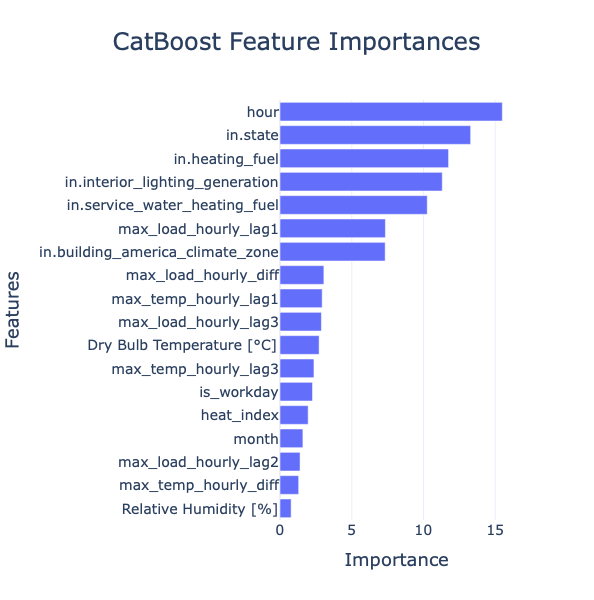

In [245]:
final_model = CatBoostRegressor()
final_model.load_model('V3education_catboost_model_tuned.cbm')

# Plot feature importances
fig = plot_feature_importances(final_model, X_train)

In [35]:
prediction_sample = final_model.predict(X_sample)
df_prediction_sample = pd.DataFrame(prediction_sample, columns=y_sample.columns, index=y_sample.index)

prediction_smape = calculate_smape(y_sample, prediction_sample)
print(f"prediction_smape: {prediction_smape}")

prediction_smape: 37.402668149388


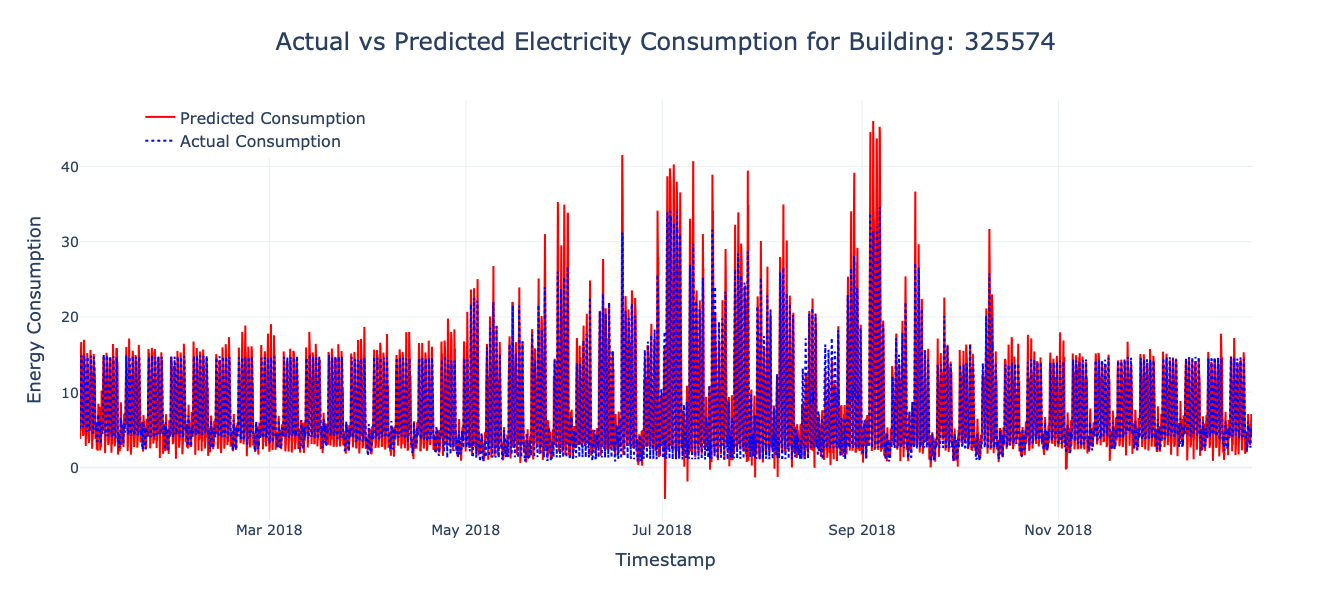

In [240]:
fig = plot_actual_vs_predicted(y_sample, df_prediction_sample, building_id=sample_bldg_id)

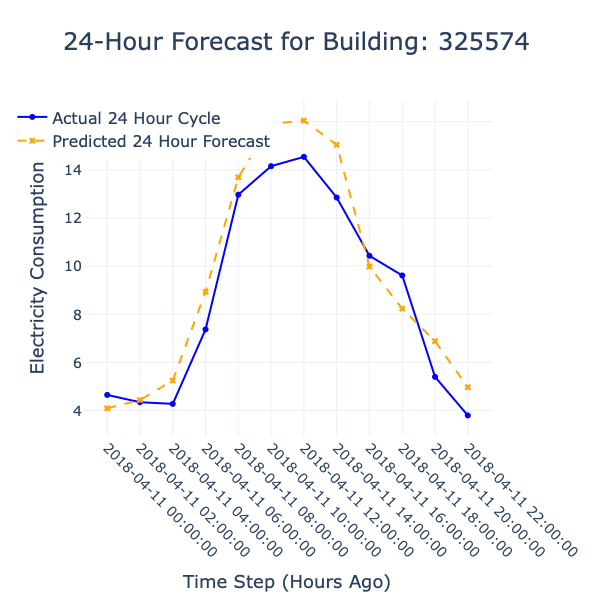

In [241]:
fig2 = visualize_24hr_catboost_forecast(y_sample, df_prediction_sample, sample_bldg_id)

In [185]:
# Can be used for future testing of creating plots with different time interval prediction and downsampling combos
# Note: model is not representative of the dataset at large and has only been trained on one building
sample_bldg_id2 = downsampled_education_train_ids[1]
X_abc, y_abc = prep_building_df(sample_bldg_id, df_metadata, downsample_time=False, prediction_interval="15_min")

categorical_features = X_abc.select_dtypes(include=['object', 'category']).columns.tolist()

train_pool = Pool(X_abc, y_abc, cat_features=categorical_features)
abc_model = CatBoostRegressor(task_type="CPU", iterations=100, depth=8, learning_rate=0.2, cat_features=categorical_features, loss_function='MultiRMSE',)
abc_model.fit(train_pool, verbose=100, early_stopping_rounds=5)

X_def, y_def = prep_building_df(sample_bldg_id, df_metadata, downsample_time=False, prediction_interval="15_min")
def_predict = abc_model.predict(X_def)
df_def_predict= pd.DataFrame(def_predict, columns=y_def.columns, index=y_def.index)

def_smape = calculate_smape(actual=y_def, predicted=def_predict)
def_smape

0:	learn: 51.9285511	total: 235ms	remaining: 23.3s
99:	learn: 21.3933658	total: 18.7s	remaining: 0us


19.87305560333588

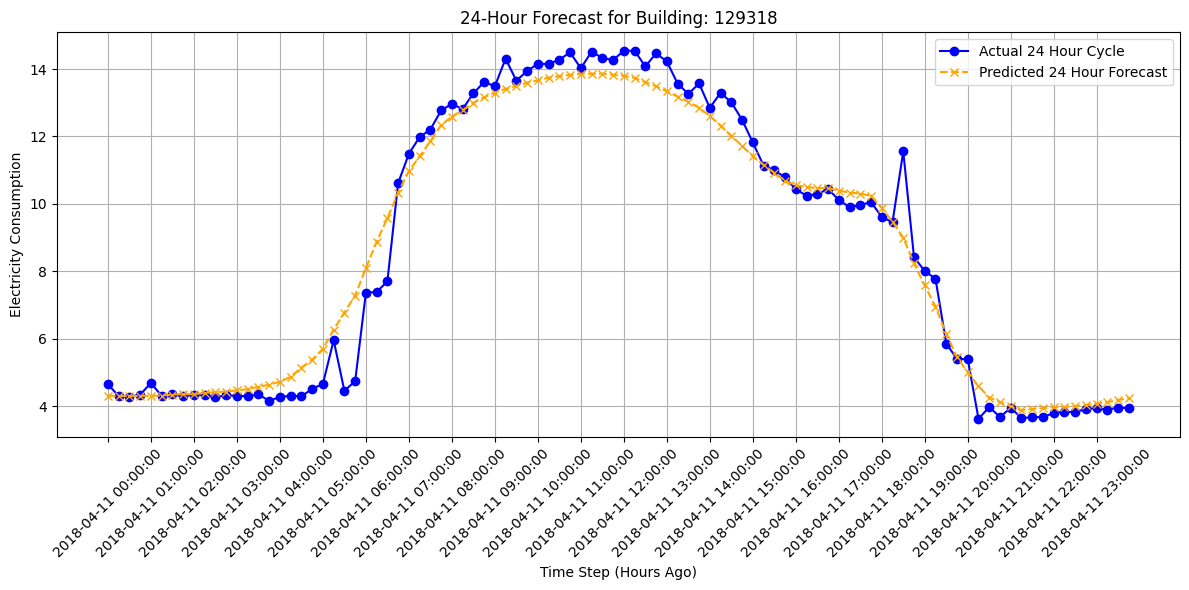

In [191]:
# Can be used for future testing of creating plots with different time interval prediction and downsampling combos
# Note: model is not representative of the dataset at large and has only been trained on one building

visualize_24hr_catboost_forecast(y_def, df_def_predict, sample_bldg_id2)